In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import logging
import random
import pkg_resources
import sklearn
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics.pairwise import pairwise_distances
#from rxnfp.tokenization import *
# from rdkit import Chem
# from rdkit.Chem import rdChemReactions
torch.cuda.is_available()
#import rxnfp
#from rxnfp.models import SmilesClassificationModel
#from rxn_yields.core import SmilesTokenizer, SmilesClassificationModel§1`

logger = logging.getLogger(__name__)
#torch.cuda.is_available()
# from simpletransformers.classification import ClassificationModel, ClassificationArgs
#from rxnfp.tokenization import SmilesTokenizer

/opt/conda/envs/reaction-workbench-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from rxnfp.tokenization import SmilesTokenizer

import os
import pickle

import argparse

from tqdm.auto import tqdm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
train = pd.read_csv('../ReactionClassification_2024/data/pub_train.tsv', sep='\t')
test = pd.read_csv('../ReactionClassification_2024/data/pub_test.tsv', sep='\t')

In [9]:
y_train = train['labels'].values
y_test = test['labels'].values

### Train Embedding

In [10]:
from transformers import AutoModel

model_path = '../Janssen_project/rxn-data-from-postgresql/models/reaxys_bert/checkpoint-4356432-epoch-36'
pretrained_model = AutoModel.from_pretrained(model_path, output_hidden_states=True)
tokenizer = SmilesTokenizer(vocab_file='../Janssen_project/rxn-data-from-postgresql/models/reaxys_bert/checkpoint-4356432-epoch-36/vocab.txt')

Some weights of BertModel were not initialized from the model checkpoint at ../Janssen_project/rxn-data-from-postgresql/models/reaxys_bert/checkpoint-4356432-epoch-36 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
df_Name=train

In [41]:
embeddings = X_train 
df_Name['embedding'] = list(embeddings)

In [46]:
class PairDataset:
    def __init__(self, dataframe):
        self.df = dataframe
        self.pairs = []
        self.targets = []
        self.create_pairs()

    def create_pairs(self):
        positive_pairs = []
        negative_pairs = []
        positive_targets = []
        negative_targets = []

        for _, group in tqdm(self.df.groupby('labels'), desc='Positive Pairs'):
            indices = group.index.tolist()
            for i in range(len(indices)):
                pair_index = (i + 1) % len(indices)
                positive_pairs.append((indices[i], indices[pair_index]))
                positive_targets.append(0)  # Positive pair (similar)
        
        labels = self.df['labels'].unique()

        for label in tqdm(labels, desc='Negative Pairs'):
            label_indices = self.df[self.df['labels'] == label].index.tolist()
            for index in label_indices:
                while True:
                    # Randomly select a different label
                    random_label = random.choice(labels)
                    if random_label != label:
                        break
                random_index = random.choice(self.df[self.df['labels'] == random_label].index.tolist())
                negative_pairs.append((index, random_index))
                negative_targets.append(1)  # Negative pair (dissimilar)
        self.pairs = positive_pairs + negative_pairs
        self.targets = positive_targets + negative_targets

    def print_sample_pairs_with_distances(self, num_samples):
        from scipy.spatial.distance import euclidean

        print("\nSample Pairs with Distances:")
        sample_indices = np.random.choice(len(self.pairs), num_samples, replace=False)
        for i, idx in enumerate(sample_indices):
            pair = self.pairs[idx]
            target = self.targets[idx]
            embedding1 = self.df.loc[pair[0], 'embedding']
            embedding2 = self.df.loc[pair[1], 'embedding']
            distance = euclidean(embedding1, embedding2)

            pair_type = "Positive" if target == 0 else "Negative"
            print(f"{pair_type} Pair {i + 1}:")
            print(f"Reaction 1 ID: {pair[0]}")
            print(f"Reaction 2 ID: {pair[1]}")
            print(f"Distance: {distance:.4f}")
            print("-" * 30)

    def calculate_average_distances(self):
        positive_distances = []
        negative_distances = []

        for idx, (index1, index2) in enumerate(self.pairs):
            embedding1 = self.df.loc[index1, 'embedding']
            embedding2 = self.df.loc[index2, 'embedding']
            distance = euclidean(embedding1, embedding2)

            if self.targets[idx] == 0:
                positive_distances.append(distance)
            else:
                negative_distances.append(distance)

        avg_positive_distance = np.mean(positive_distances)
        avg_negative_distance = np.mean(negative_distances)

        print(f"Average Positive Pair Distance: {avg_positive_distance:.4f}")
        print(f"Average Negative Pair Distance: {avg_negative_distance:.4f}")

    def plot_distance_distributions(self, num_samples=100):
        positive_distances = []
        negative_distances = []

        sample_indices = np.random.choice(len(self.pairs), num_samples, replace=False)
        for idx in sample_indices:
            pair = self.pairs[idx]
            target = self.targets[idx]
            embedding1 = self.df.loc[pair[0], 'embedding']
            embedding2 = self.df.loc[pair[1], 'embedding']
            distance = euclidean(embedding1, embedding2)

            if target == 0:
                positive_distances.append(distance)
            else:
                negative_distances.append(distance)

        plt.hist(positive_distances, bins=30, alpha=0.5, label='Positive Pairs')
        plt.hist(negative_distances, bins=30, alpha=0.5, label='Negative Pairs')
        plt.xlabel('Distance')
        plt.ylabel('Frequency')
        plt.title('Distance Distribution of Positive and Negative Pairs')
        plt.legend(loc='upper right')
        plt.show()

In [47]:
sample_fraction = 0.5  # Use 50% of the data
sample_df = df_Name.sample(frac=sample_fraction, random_state=42)

# Create the dataset and dataloaders
dataset = PairDataset(sample_df)

Negative Pairs: 100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]


In [48]:
print(f"Total number of positive pairs: {sum(1 for t in dataset.targets if t == 1)}")
print(f"Total number of negative pairs: {sum(1 for t in dataset.targets if t == 0)}")

Total number of positive pairs: 200302
Total number of negative pairs: 200302


In [49]:
dataset.calculate_average_distances()

Average Positive Pair Distance: 1.8285
Average Negative Pair Distance: 2.2569


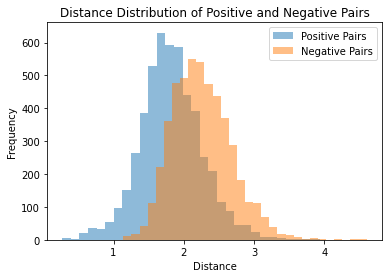

In [50]:
dataset.plot_distance_distributions(10000)

In [51]:
class ReactionPairDataset(Dataset):
    def __init__(self, dataframe, pairs, targets):
        self.df = dataframe
        self.pairs = pairs
        self.targets = targets

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        index1, index2 = self.pairs[idx]
        reaction1 = self.df.loc[index1, 'canonical_rxn_with_fragment_info']
        reaction2 = self.df.loc[index2, 'canonical_rxn_with_fragment_info']
        label = self.targets[idx]
        return reaction1, reaction2, torch.tensor(label, dtype=torch.float32)

In [52]:
reaction_dataset = ReactionPairDataset(df_Name, dataset.pairs, dataset.targets)
train_size = int(0.9 * len(reaction_dataset))
val_size = len(reaction_dataset) - train_size
train_dataset, val_dataset = random_split(reaction_dataset, [train_size, val_size])

In [53]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(987, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


In [55]:
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=1e-6) 
total_steps = len(train_dataloader) * 10  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [58]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

In [59]:
criterion = ContrastiveLoss(margin=2)

In [60]:
def evaluate_model(dataloader):
    pretrained_model.eval()
    total_loss = 0
    with torch.no_grad():
        for reaction1, reaction2, target in dataloader:
            inputs1 = tokenizer(reaction1, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
            inputs2 = tokenizer(reaction2, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
            target = target.to(device)
            
            embedding1 = pretrained_model(**inputs1).last_hidden_state[:, 0, :]
            embedding2 = pretrained_model(**inputs2).last_hidden_state[:, 0, :]
            
            loss = criterion(embedding1, embedding2, target)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [61]:
num_epochs = 5
accumulation_steps = 4 
#early_stopping_patience = 3
best_val_loss = float('inf')
#patience_counter = 0
scaler = torch.cuda.amp.GradScaler()
for epoch in range(num_epochs):
    pretrained_model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", mininterval=1)  # Update every 100 seconds
    optimizer.zero_grad()

    for i, (reaction1, reaction2, target) in enumerate(progress_bar):
        inputs1 = tokenizer(reaction1, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        inputs2 = tokenizer(reaction2, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        target = target.to(device)

        with torch.cuda.amp.autocast():
            embedding1 = pretrained_model(**inputs1).last_hidden_state[:, 0, :]
            embedding2 = pretrained_model(**inputs2).last_hidden_state[:, 0, :]
            loss = criterion(embedding1, embedding2, target)
            loss = loss / accumulation_steps  # Scale the loss

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(pretrained_model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

        # Print loss less frequently
        if (i + 1) % (len(train_dataloader) // 10) == 0:
            progress_bar.set_postfix(loss=total_loss / ((i + 1) // accumulation_steps if (i + 1) // accumulation_steps > 0 else 1))

    val_loss = evaluate_model(val_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss / len(train_dataloader)}, Validation Loss: {val_loss}")

    scheduler.step()

Epoch 1/5: 100%|██████████| 11267/11267 [20:40<00:00,  9.08it/s, loss=6.2] 


Epoch 1/5, Training Loss: 1.5493613505909412, Validation Loss: 0.32532729238224106


Epoch 2/5: 100%|██████████| 11267/11267 [20:42<00:00,  9.07it/s, loss=2.1] 


Epoch 2/5, Training Loss: 0.5243102118202309, Validation Loss: 0.22996507489833587


Epoch 3/5: 100%|██████████| 11267/11267 [20:50<00:00,  9.01it/s, loss=1.73]


Epoch 3/5, Training Loss: 0.4314229673384202, Validation Loss: 0.19844357477138028


Epoch 4/5: 100%|██████████| 11267/11267 [20:55<00:00,  8.98it/s, loss=1.52]


Epoch 4/5, Training Loss: 0.3793551168401461, Validation Loss: 0.17702412028639272


Epoch 5/5: 100%|██████████| 11267/11267 [20:48<00:00,  9.02it/s, loss=1.38]


Epoch 5/5, Training Loss: 0.34411742976572646, Validation Loss: 0.16152286386718384


In [62]:
pretrained_model.save_pretrained('data/fine_tuned_model_Pub')
tokenizer.save_pretrained('data/fine_tuned_model_Pub')

('data/fine_tuned_model_Pub/tokenizer_config.json',
 'data/fine_tuned_model_Pub/special_tokens_map.json',
 'data/fine_tuned_model_Pub/vocab.txt',
 'data/fine_tuned_model_Pub/added_tokens.json')


### Data Load

In [37]:
X_train = np.load('../ReactionClassification_2024/data/PreBertFP_Pub/X_train_PreBertFP.npy',allow_pickle=True)

In [38]:
X_train1 = np.vstack(X_train)
X_train = np.squeeze(X_train1)

In [39]:
#X_train = np.load('data/RXNFP/X_train_RXNFP.npy')
X_test = np.load('../ReactionClassification_2024/data/PreBertFP_Pub/X_test_PreBertFP.npy',allow_pickle=True)
#X_val = np.load('../ReactionClassification_2024/data/PreBertFP_Pub/X_val_PreBertFP.npy',allow_pickle=True)

In [40]:
X_test1 = np.vstack(X_test)
X_test = np.squeeze(X_test1)